In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 10 20:38:57 2021

@author: GERMANBARCENAS
"""

#%% Modules
import re
import pandas as pd
import rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import rdDepictor
from rdkit.Chem import Crippen
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
from rdkit.Chem import rdAbbreviations
from rdkit.Chem import rdmolops
import openbabel
from openbabel import openbabel as ob
from matplotlib.colors import ColorConverter
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG
print("RDKit:"+rdkit.__version__)
print("OpenBabel:"+openbabel.__version__)
print("numpy:"+np.__version__)

from platform import python_version
print("Python:"+python_version())

#%% Functions:

def groups_to_df(groups,mols,include_core=False,redraw_sidechains=False):
    """ add the molecule to the dataframe 
    """
    cols = ['Mol']+list(groups.keys())
    if redraw_sidechains:
        for k,vl in groups.items():
            if k=='Core':
                continue
            for i,v in enumerate(vl):
                vl[i] = Chem.RemoveHs(v)
                rdDepictor.Compute2DCoords(vl[i])

    
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = mols
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame    

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def GetRingSystems(mol, includeSpiro=False):
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

def find_bond_groups(mol,atom_pairs):
    """Find groups of contiguous rotatable bonds and return them sorted by decreasing size"""
    bond_set = set([mol.GetBondBetweenAtoms(*ap).GetIdx() for ap in atom_pairs])
    bond_groups = []
    while (bond_set):
        i = bond_set.pop()
        connected_bond_set = set([i])
        stack = [i]
        while (stack):
            i = stack.pop()
            b = mol.GetBondWithIdx(i)
            bonds = []
            for a in (b.GetBeginAtom(), b.GetEndAtom()):
                bonds.extend([b.GetIdx() for b in a.GetBonds() if (
                    (b.GetIdx() in bond_set) and (not (b.GetIdx() in connected_bond_set)))])
            connected_bond_set.update(bonds)
            stack.extend(bonds)
        bond_set.difference_update(connected_bond_set)
        bond_groups.append(tuple(connected_bond_set))
    return tuple(sorted(bond_groups, reverse = True, key = lambda x: len(x)))


RDKit:2021.09.5
OpenBabel:3.1.0
numpy:1.20.3
Python:3.9.7


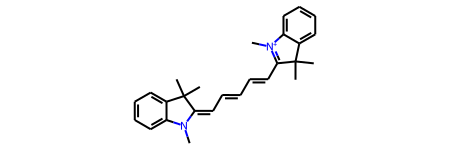

In [2]:
#%% Read SMILES Input and name
dyeName='cy5'
smiles={
        'bisr1-o2':'O=c6c(c5ccc(N4CCN(c3ccc(c2c([O-])c(=c1ccc(=N(=O)[O-])cc1)c2=O)cc3)CC4)cc5)c([O-])c6=C7C=CC(N([O-])[O-])C=C7',
        'bisr1-h': '[NH2+]=c7ccc(=c6c([O-])c(c5ccc(N4CCN(c3ccc(c2c([O-])c(=c1ccc(=[NH2+])cc1)c2=O)cc3)CC4)cc5)c6=O)cc7',
        'bissq1-cl': 'CN9/C(=C/c7c([O-])c(=CC2=[N+](C)c1cc6c(cc1C2(C)C)[N+](C)=C(C=c5c([O-])c(/C=C/4N(C)c3ccc(Cl)cc3C4(C)C)c5=O)C6(C)C)c7=O)C(C)(C)c8cc(Cl)ccc89',
        'bissq1-h' : 'CN9/C(=C/c7c([O-])c(=CC2=[N+](C)c1cc6c(cc1C2(C)C)[N+](C)=C(C=c5c([O-])c(/C=C/4N(C)c3ccccc3C4(C)C)c5=O)C6(C)C)c7=O)C(C)(C)c8ccccc89',
        'bissq4' : 'CN%11/C(=C\c9c([O-])c(=CC2=[N+](CCCCS(=O)(=O)O)c1cc4c(cc1C2(C)C)C(C)(C)c3cc8c(cc3C4(C)C)C(C)(C)C(C=c7c([O-])c(/C=C/6N(C)c5ccccc5C6(C)C)c7=O)=[N+]8CCCCS(=O)(=O)O)c9=O)C(C)(C)c%10ccccc%10%11',
        'r-f' : 'O=C2NCc5c(F)c(F)c(CNC(=O)c1cccc(n1)C(=O)NCc4c(F)c(F)c(CNC(=O)c3cccc2n3)c(F)c4F)c(F)c5F',
        'sr16' : 'C[N+]5=C(C=c3c([O-])c(C=C2Nc1ccc(Cl)cc1C2(C)C)c3=O)C(C)(C)c4cc(Cl)ccc45',
        'sr30' : 'C[N+]5=C(C=c3c([O-])c(C=C2Nc1ccc(S(=O)(=O)O)cc1C2(C)C)c3=O)C(C)(C)c4cc(S(=O)(=O)O)ccc45',
        'sr31' : 'C[N+]5=C(C=c3c([O-])c(C=C2Nc1ccc(S(N)(=O)=O)cc1C2(C)C)c3=O)C(C)(C)c4cc(Cl)ccc45',
        'sr32' : 'C[N+]5=C(C=c3c([O-])c(C=C2Nc1ccc(S(N)(=O)=O)cc1C2(C)C)c3=O)C(C)(C)c4cc(S(N)(=O)=O)ccc45',
        'chlorin' : 'C1CC2=NC1=CC3=CC=C(N3)C=C4C=CC(=N4)C=C5C=CC(=C2)N5',
        'chlorin-meso' : 'C1CC2=NC1=C([*:1])C3=CC=C(N3)C([*:2])=C4C=CC(=N4)C([*:3])=C5C=CC(=C2([*:4]))N5',
        'chlorin-meta' : 'C1([*:6])C([*:5])C2=NC1=CC3=C([*:7])C([*:8])=C(N3)C=C4C([*:9])=C([*:10])C(=N4)C=C5C([*:11])=C([*:12])C(=C2)N5',
        'chlorin-all' : 'C1([*:6])C([*:5])C2=NC1=C([*:1])C3=C([*:7])C([*:8])=C(N3)C([*:2])=C4C([*:9])=C([*:10])C(=N4)C([*:3])=C5C([*:11])=C([*:12])C(=C2([*:4]))N5',
        'ciprofloxacin' : 'C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O',
        'cy5' : 'CN4/C(=C/C=C/C=C/C2=[N+](C)c1ccccc1C2(C)C)C(C)(C)c3ccccc34',
        'sq' : 'CN5/C(=C/c3c([O-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=O)C(C)(C)c4ccccc45',
        'sq-test' : 'CN5/C(=C/c3c([*:1])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=[*:1])C(C)(C)c4ccccc45',
        'sq-thio' : 'CN5/C(=C/c3c([S-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=S)C(C)(C)c4ccccc45',
        'sq-se' : 'CN5/C(=C/c3c([Se-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=[Se])C(C)(C)c4ccccc45',
        'sq-te' : 'CN5/C(=C/c3c([Te-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=[Te])C(C)(C)c4ccccc45',
        'sq-nme2' : 'CN(C)c1ccc5c(c1)N(C)/C(=C/c4c([O-])c(=CC3=[N+](C)c2ccccc2C3(C)C)c4=O)C5(C)C',
        'sq-no2-nme2' : 'CN(C)c1ccc5c(c1)N(C)/C(=C/c4c([O-])c(=CC3=[N+](C)c2ccc(N(=O)=O)cc2C3(C)C)c4=O)C5(C)C',
        'sqSS' : 'Cn5c(=Cc3c([O-])c(=Cc2sc1ccccc1[n+]2C)c3=O)sc4ccccc45',
        'sqSSe' : 'Cn5c(=Cc3c([O-])c(=Cc2sc1ccccc1[n+]2C)c3=O)[se]c4ccccc45',
        'sqSeSe' : 'Cn5c(=Cc3c([O-])c(=Cc2[se]c1ccccc1[n+]2C)c3=O)[se]c4ccccc45',
        'sqSe' : 'Cn5c(=Cc3c([O-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=O)[se]c4ccccc45',
        'sqS' : 'Cn5c(=Cc3c([O-])c(=CC2=[N+](C)c1ccccc1C2(C)C)c3=O)sc4ccccc45'
        }

smiles_INPUT=smiles[dyeName]
molecule=Chem.MolFromSmiles(smiles_INPUT)
rdDepictor.Compute2DCoords(molecule)
charge=Chem.GetFormalCharge(molecule)

molecule
#mol_with_atom_index(molecule)

π conjugation bond count = 22
Longest bond distance in π chain: 16.0
Heavy Atoms in π conjugation =  21
log(P)= 6.117
Formal Charge of Molecule 1


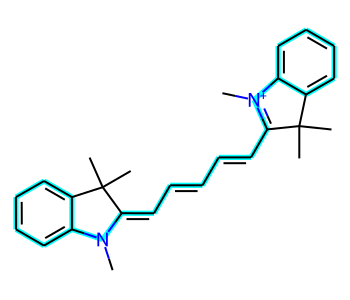

In [3]:
#%% Identify strucutural features 
originalSanitized=Chem.SanitizeMol(molecule,catchErrors=True)
supp=Chem.ResonanceMolSupplier(molecule)
conjugatedGroupNumber=supp.GetNumConjGrps()

conjugatedAtoms=[]
conjugatedBonds=[]
conjugatedAtomsList= [[] for i in range(conjugatedGroupNumber+1)]
conjugatedBondsList= [[] for i in range(conjugatedGroupNumber+1)]
for idx,bond in  enumerate(molecule.GetBonds()):
    if bond.GetIsConjugated()==True:
        a1=bond.GetBeginAtomIdx()
        a2=bond.GetEndAtomIdx()
        conjugatedAtoms.append([a1,a2])
        conjugatedBondIndex=molecule.GetBondBetweenAtoms(a1,a2).GetIdx()
        conjugatedBonds.append(conjugatedBondIndex)
        conjugatedGroup=supp.GetBondConjGrpIdx(conjugatedBondIndex)
        conjugatedAtomsList[conjugatedGroup].append([a1,a2])
        conjugatedBondsList[conjugatedGroup].append(conjugatedBondIndex)
    
    
    
conjugatedBondsList.sort(key=len,reverse=True)
conjugatedAtomsList.sort(key=len,reverse=True)

conjugatedAtomsFlatList = []
for sublist in conjugatedAtoms:
    for item in sublist:
        conjugatedAtomsFlatList.append(item)
        
# Draw figure with indices to check
rdDepictor.Compute2DCoords(molecule)

#%% Crippen logP
logP=Chem.Crippen.MolLogP(molecule,includeHs=True)

chainMap={}
chain=Chem.PathToSubmol(molecule,conjugatedBondsList[0],atomMap=chainMap)
originalSanitized=Chem.SanitizeMol(chain,catchErrors=True)
distances=Chem.GetDistanceMatrix(chain)
maxDistances = [max(i) for i in distances]
maxPiDistance=max(maxDistances)
map_list=[chainMap[x] for x in sorted(chainMap)]
heavyatoms=chain.GetNumHeavyAtoms()

#%% Results
print('\u03C0 conjugation bond count =',len(conjugatedBondsList[0]))
print("Longest bond distance in \u03C0 chain:",maxPiDistance)
print('Heavy Atoms in \u03C0 conjugation = ',heavyatoms)
print('log(P)=',round(logP,3))
print('Formal Charge of Molecule',charge)


d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
dos = d2d.drawOptions()
dos.setHighlightColour((0,1,1))
dos.atomHighlightsAreCircles = True
dos.fillHighlights=False
d2d.drawOptions().addAtomIndices=False
d2d.drawOptions().addBondIndices=False
d2d.DrawMolecule(molecule,highlightBonds=conjugatedBonds,highlightAtoms=[])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())
#d2d.GetDrawingText()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Longest bond distance in π chain: 18.0
Longest literal distance in π chain: 20.692288208862983


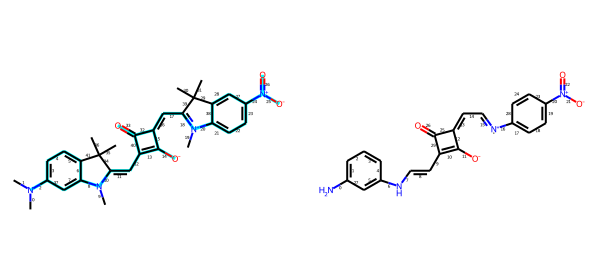

In [199]:
# information of pi chain
# 3D information
m_3d=Chem.AddHs(molecule)
AllChem.EmbedMolecule(m_3d,randomSeed=0xf00d)
chainMap={}
chain=Chem.PathToSubmol(molecule,conjugatedBondsList[0],atomMap=chainMap)
originalSanitized=Chem.SanitizeMol(chain,catchErrors=True)
#print(Chem.MolToMolBlock(chain))
distances=Chem.GetDistanceMatrix(chain)
maxDistances = [max(i) for i in distances]
maxPiDistance=max(maxDistances)
map_list=[chainMap[x] for x in sorted(chainMap)]
print(map_list)
print("Longest bond distance in \u03C0 chain:",maxPiDistance)
threedDistance=molDG.GetMoleculeBoundsMatrix(chain)
maxThreeDDistance = [max(i) for i in threedDistance]
maxPiTheeDDistance=max(maxThreeDDistance)
print("Longest literal distance in \u03C0 chain:",maxPiTheeDDistance)

d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
dos = d2d.drawOptions()
dos.setHighlightColour((0,1,1))
dos.atomHighlightsAreCircles = True
dos.fillHighlights=False
#d2d.drawOptions().addAtomIndices=True
d2d.drawOptions().addBondIndices=True
d2d.DrawMolecules([molecule,chain],highlightBonds=[conjugatedBondsList[0],[]],highlightAtoms=[])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())
#d2d.GetDrawingText()



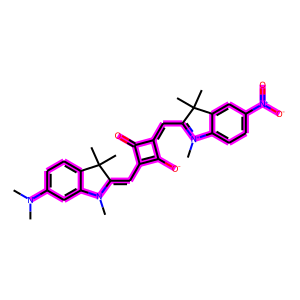

In [200]:
#mol_with_atom_index(m)
img_highlight = Draw.MolToImage(molecule,highlightBonds=conjugatedBonds,highlightColor=ColorConverter().to_rgb('magenta'))
#img_highlight.save("highlight.png",highlightAtoms=[1],highlightColor=ColorConverter().to_rgb('blue'))

img_highlight

In [201]:
#%% Crippen logP
logP=Chem.Crippen.MolLogP(molecule,includeHs=True)
print(logP)

4.101800000000003


CN(C)c1ccc5c(c1)N(C)/C(=C/c4c([O-])c(=CC3=[N+](C)c2ccc(N(=O)=O)cc2C3(C)C)c4=O)C5(C)C
CN(C)c1ccc5c(c1)N(C)/C(=C/c4c([O-])c(=CC3=[N+](C)c2ccc(N(=O)=O)cc2C3(C)C)c4=O)C5(C)C


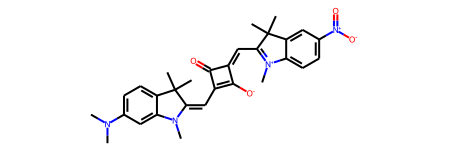

In [202]:
#%% Create new molecules from scaffold
smiles_new=smiles_INPUT.replace('[*:1]','C(=O)-C')
smiles_new=smiles_new.replace('([*:5])','(C)(C)')
smiles_new=smiles_new.replace('[*:3]','C#CC1=C-C=C(C)C=C1')
smiles_new=smiles_new.replace('[*:4]','C(=O)-C')
smiles_new=smiles_new.replace('[*:7]','N([O-])([O-])')
# remove placeholders to convert smi to gjf 
pattern_to_remove=r'\[\*.*?\]'
smiles_clean=re.sub(pattern_to_remove, "", smiles_new)
pattern_to_remove=r'\(\)'
smiles_clean=re.sub(pattern_to_remove, "", smiles_clean)
print(smiles_new)
print(smiles_clean)
molecule_new=Chem.MolFromSmiles(smiles_clean)
rdDepictor.Compute2DCoords(molecule_new)
molecule_new


In [203]:
#%% Create 3D .pdb from 2D SMILES
molecule_3d=Chem.AddHs(molecule_new)
AllChem.EmbedMolecule(molecule_3d)
#molecule_3d.GetNumConformers()
AllChem.UFFOptimizeMolecule(molecule_3d)
molecule_3d.SetProp('_Name',"%s.png" %dyeName)
Chem.MolToPDBFile(molecule_3d,'%s.pdb'%dyeName)

In [204]:
#%% Save image files
img_og = Draw.MolToImage(molecule)
img_new = Draw.MolToImage(molecule_new)
img_og.save("%s-original.png" %dyeName,highlightAtoms=[1,2],highlightColor=ColorConverter().to_rgb('red'))
img_new.save("%s.png" %dyeName)

In [205]:
#%% Create .gjf from .pdb using OpenBabel
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("pdb", "gjf")
mol = ob.OBMol()
obConversion.ReadFile(mol,'%s.pdb' %dyeName)
obConversion.WriteFile(mol, '%s_gs_opt_m062x_vacuum.gjf' %dyeName)

True

In [206]:
#%% Write Gaussian Inputs into generated .gjf file
with open('%s_gs_opt_m062x_vacuum.gjf' %dyeName,'r') as file:
        data = file.readlines()
        data[0]='%%chk=%s_gs_opt_m062x_vacuum.chk\n'%dyeName
        data[1]='%nprocshared=48\n'
        data[2]='%mem=20GB\n'
        data[3]='# opt=tight m062x/6-31+g(d,p) density=current int=ultrafine\n\n'
        data[4]='%s\n\n'%dyeName
        print(data)
        
with open('%s_gs_opt_m062x_vacuum.gjf' %dyeName, 'w') as file:
    file.writelines( data )


['%chk=sq-no2-nme2_gs_opt_m062x_vacuum.chk\n', '%nprocshared=48\n', '%mem=20GB\n', '# opt=tight m062x/6-31+g(d,p) density=current int=ultrafine\n\n', 'sq-no2-nme2\n\n', '0  1\n', 'C           9.51600        -0.80000         0.32800\n', 'N           8.33000        -1.54800        -0.10800\n', 'C           8.51800        -2.76000        -0.91800\n', 'C           6.99700        -1.09400         0.24800\n', 'C           6.80200        -0.17300         1.31100\n', 'C           5.52000         0.28200         1.64700\n', 'C           4.42400        -0.19000         0.92200\n', 'C           4.58900        -1.09500        -0.09700\n', 'C           5.86000        -1.55500        -0.46300\n', 'N           3.34300        -1.44100        -0.68700\n', 'C           3.13200        -2.37400        -1.79600\n', 'C           2.33900        -0.65100        -0.02000\n', 'C           1.04200        -0.68400        -0.40700\n', 'C          -0.13300         0.04000         0.14100\n', 'C          -1.40600   

In [185]:
#%% Iterate on Scaffold for Meso- Substition

# List of functional groups to add to scaffold

# for string in list of functional groups, swap *:1 with functional group
# for string in list of functional groups, swap *:2 with functional group
# for string in list of functional groups, swap *:3 with functional group
# for string in list of functional groups, swap *:4 with functional group
# for string in list of functional groups, swap *:1 and *:2 with functional group
# for string in list of functional groups, swap *:1 and *:3 with functional group
# for string in list of functional groups, swap *:1 and *:4 with functional group
# for string in list of functional groups, swap *:2 and *:3 with functional group
# for string in list of functional groups, swap *:2 and *:4 with functional group
# for string in list of functional groups, swap *:2 and *:4 with functional group
# for string in list of functional groups, swap *:3 and *:4 with functional group


In [119]:
#%% Iterate on Scaffold for Meta- Substition

# List of functional groups to add to scaffold

# for string in list of functional groups, swap *:5 with functional group
# for string in list of functional groups, swap *:6 with functional group
# for string in list of functional groups, swap *:7 with functional group
# for string in list of functional groups, swap *:8 with functional group
# for string in list of functional groups, swap *:9 with functional group
# for string in list of functional groups, swap *:10 with functional group
# for string in list of functional groups, swap *:11 with functional group
# for string in list of functional groups, swap *:12 with functional group
# for string in list of functional groups, swap *:5 and *:6 with functional group
# for string in list of functional groups, swap *:5 and *:7 with functional group
# for string in list of functional groups, swap *:5 and *:8 with functional group
# for string in list of functional groups, swap *:5 and *:9 with functional group
# for string in list of functional groups, swap *:5 and *:10 with functional group
# for string in list of functional groups, swap *:5 and *:11 with functional group
# for string in list of functional groups, swap *:5 and *:12 with functional group
# for string in list of functional groups, swap *:6 and *:7 with functional group
# for string in list of functional groups, swap *:6 and *:8 with functional group
# for string in list of functional groups, swap *:6 and *:9 with functional group
# for string in list of functional groups, swap *:6 and *:10 with functional group
# for string in list of functional groups, swap *:6 and *:11 with functional group
# for string in list of functional groups, swap *:6 and *:12 with functional group
# for string in list of functional groups, swap *:7 and *:8 with functional group
# for string in list of functional groups, swap *:6 and *:9 with functional group
# for string in list of functional groups, swap *:6 and *:10 with functional group
# for string in list of functional groups, swap *:6 and *:11 with functional group
# for string in list of functional groups, swap *:6 and *:12 with functional group
# for string in list of functional groups, swap *:7 and *:8 with functional group
# for string in list of functional groups, swap *:7 and *:9 with functional group
# for string in list of functional groups, swap *:7 and *:10 with functional group
# for string in list of functional groups, swap *:7 and *:11 with functional group
# for string in list of functional groups, swap *:7 and *:12 with functional group
# for string in list of functional groups, swap *:8 and *:9 with functional group
# for string in list of functional groups, swap *:8 and *:10 with functional group
# for string in list of functional groups, swap *:8 and *:11 with functional group
# for string in list of functional groups, swap *:8 and *:12 with functional group
# for string in list of functional groups, swap *:9 and *:10 with functional group
# for string in list of functional groups, swap *:9 and *:11 with functional group
# for string in list of functional groups, swap *:9 and *:12 with functional group
# for string in list of functional groups, swap *:10 and *:11 with functional group
# for string in list of functional groups, swap *:10 and *:12 with functional group
# for string in list of functional groups, swap *:11 and *:12 with functional group

In [120]:
# for string in list of functional groups, swap *:5 , *:6 , *:7 with functional group....